In [1]:
import pandas as pd
import numpy as np
from unidecode import unidecode
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
## load in football manager data from web scraping
df = pd.read_csv('fm_player_data_3.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 49 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        10000 non-null  int64  
 1   player_name       10000 non-null  object 
 2   link              10000 non-null  object 
 3   club              9844 non-null   object 
 4   country           10000 non-null  object 
 5   age               10000 non-null  object 
 6   position          10000 non-null  object 
 7   foot              10000 non-null  object 
 8   height            10000 non-null  object 
 9   weight            10000 non-null  object 
 10  player_id         10000 non-null  float64
 11  wages             10000 non-null  object 
 12  contract_end      10000 non-null  object 
 13  Corners           10000 non-null  int64  
 14  Crossing          10000 non-null  int64  
 15  Dribbling         10000 non-null  int64  
 16  Finishing         10000 non-null  int64  

In [3]:
## setting free agents wages and contracts to 0
df['club'] = df['club'].fillna('Free-Agent')
df.loc[df['club'] == 'Free-Agent', 'wages'] = 0
df.loc[df['club'] == 'Free-Agent', 'contract_end'] = 0

In [4]:
#drop duplicates
df = df.drop_duplicates()

#drop goalkeepers
df.drop(df[df['position'] == 'GKGK'].index, inplace=True)

In [5]:
## cleaning and converting the age column
df = df[df['age'].str.match(r'\b\d{2}\b')]
df['age'] = df['age'].astype(int)

In [6]:
## drop additional index
df.drop(columns='Unnamed: 0',inplace= True)

In [7]:
#creating a column with the sum of stats
stats = ['Corners', 'Crossing', 'Dribbling', 'Finishing', 'First Touch',
            'Free Kick Taking', 'Heading',
          'Long Shots', 'Long Throws', 'Marking', 'Passing', 'Penalty Taking',
          'Tackling', 'Technique', 'Aggression', 'Anticipation', 'Bravery',
          'Composure', 'Concentration', 'Decisions', 'Determination', 'Flair',
          'Leadership', 'Off the Ball', 'Positioning', 'Teamwork', 'Vision',
          'Work Rate', 'Acceleration', 'Agility', 'Balance', 'Jumping Reach',
          'Natural Fitness', 'Pace', 'Stamina', 'Strength']

df['sum_stats'] = df[stats].sum(axis=1)

In [9]:
# load in transfermarkt data
df_player = pd.read_csv('players.csv')
df_player.drop_duplicates(inplace= True)
df_player.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24616 entries, 0 to 24615
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   player_id                    24616 non-null  int64  
 1   pretty_name                  24616 non-null  object 
 2   club_id                      24616 non-null  int64  
 3   club_pretty_name             24616 non-null  object 
 4   current_club_id              24616 non-null  int64  
 5   country_of_citizenship       24615 non-null  object 
 6   country_of_birth             23010 non-null  object 
 7   date_of_birth                24592 non-null  object 
 8   position                     24616 non-null  object 
 9   sub_position                 21660 non-null  object 
 10  name                         24616 non-null  object 
 11  foot                         22822 non-null  object 
 12  height_in_cm                 24616 non-null  int64  
 13  market_value_in_

In [10]:
## match name format between both tables
df['lower_name'] = df['player_name'].apply(lambda x: x.lower().replace(' ','-'))
df['name'] = df['lower_name'].apply(lambda x: unidecode(x))

In [11]:
## creating a data set for valuation model with no duplicated names
df_dup = df.name.value_counts().reset_index()
df_dup = df_dup[df_dup['name']>1]
df_reg = df[~df['name'].isin(df_dup['index'])].reset_index()
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8576 entries, 0 to 8575
Data columns (total 52 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             8576 non-null   int64  
 1   player_name       8576 non-null   object 
 2   link              8576 non-null   object 
 3   club              8576 non-null   object 
 4   country           8576 non-null   object 
 5   age               8576 non-null   int32  
 6   position          8576 non-null   object 
 7   foot              8576 non-null   object 
 8   height            8576 non-null   object 
 9   weight            8576 non-null   object 
 10  player_id         8576 non-null   float64
 11  wages             8576 non-null   object 
 12  contract_end      8576 non-null   object 
 13  Corners           8576 non-null   int64  
 14  Crossing          8576 non-null   int64  
 15  Dribbling         8576 non-null   int64  
 16  Finishing         8576 non-null   int64  


In [12]:
#to create valuation test set, join dataframes on name and remove players which don't have values
player_cols = ['market_value_in_gbp','highest_market_value_in_gbp','image_url','name']
df_merge = pd.merge(df_reg,df_player[player_cols],how= 'left', on = 'name').reset_index()
df_merge.dropna(subset=['market_value_in_gbp'], inplace=True)

# EDA

In [13]:
#overview of market value data
df_merge['market_value_in_gbp'].describe()

count    5.031000e+03
mean     5.118805e+06
std      9.796973e+06
min      2.300000e+04
25%      7.200000e+05
50%      1.800000e+06
75%      4.500000e+06
max      1.440000e+08
Name: market_value_in_gbp, dtype: float64

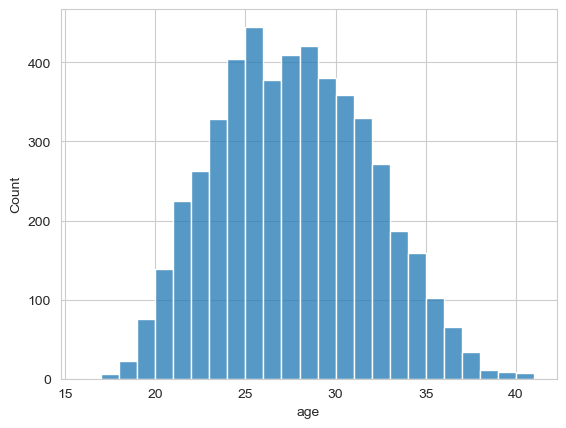

In [14]:
# age distribution
X = df_merge['age']
sns.histplot(x=X,bins= X.max()-X.min())

plt.show()

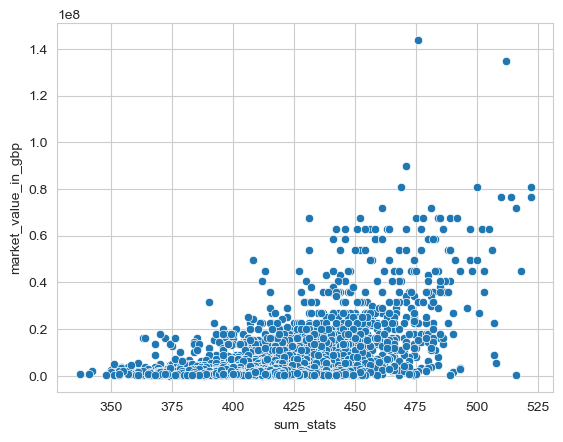

In [15]:
#market value vs sum stats shows exponential trend
sns.scatterplot(data= df_merge,x= 'sum_stats',y= 'market_value_in_gbp')
plt.show()

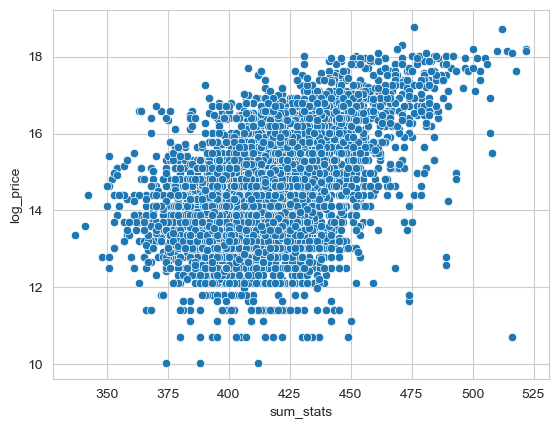

In [16]:
#log of price

df_merge['log_price'] = np.log(df_merge['market_value_in_gbp'])

sns.scatterplot(data= df_merge,x= 'sum_stats',y= 'log_price')
plt.show()

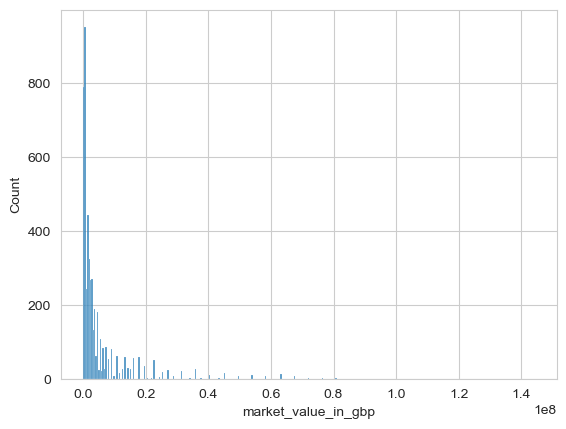

In [17]:
# market value distribution
X = df_merge['market_value_in_gbp']
sns.histplot(x=X)

plt.show()

In [18]:
# remove outliers in the market value
#more relevant to get the majority of players price close to the true value than extreme cases
stdev = df_merge['market_value_in_gbp'].std()
mean = df_merge['market_value_in_gbp'].mean()
df_merge = df_merge[(df_merge['market_value_in_gbp'] <= (mean + 3*stdev)) & (df_merge['market_value_in_gbp'] >= (mean - 3*stdev))]


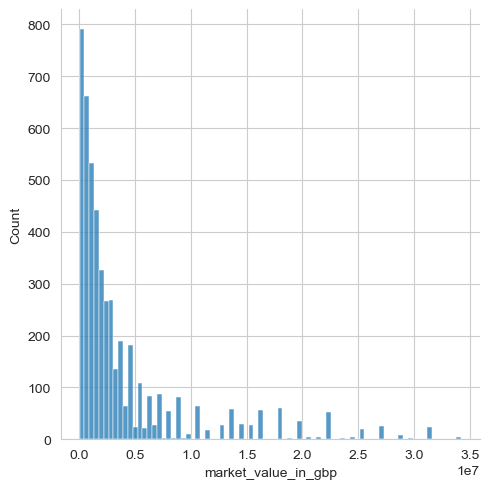

In [19]:
#market value without outliers
X = df_merge['market_value_in_gbp']
sns.displot(x=X)

plt.show()

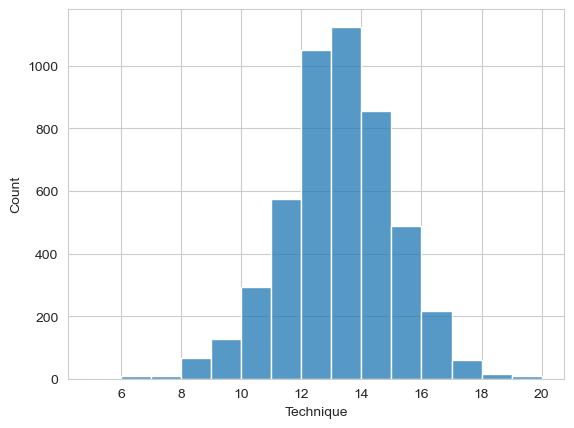

In [20]:
#distribution of technique
X = df_merge['Technique']
sns.histplot(x=X,bins= X.max()-X.min())

plt.show()

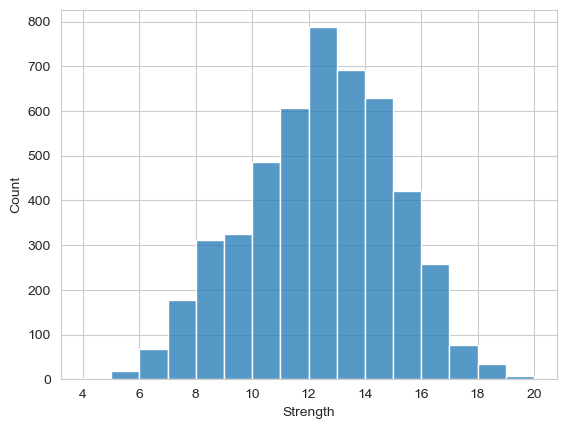

In [21]:
#distribution of strength
X = df_merge['Strength']
sns.histplot(x=X,bins= X.max()-X.min())

plt.show()

## Valuation Model with 3 features at first

In [22]:
## Train Test Split
from sklearn.model_selection import train_test_split

# #select feature columns
# features = ['age', 'Corners', 'Crossing', 'Dribbling', 'Finishing', 'First Touch',
#             'Free Kick Taking', 'Heading',
#           'Long Shots', 'Long Throws', 'Marking', 'Passing', 'Penalty Taking',
#           'Tackling', 'Technique', 'Aggression', 'Anticipation', 'Bravery',
#           'Composure', 'Concentration', 'Decisions', 'Determination', 'Flair',
#           'Leadership', 'Off the Ball', 'Positioning', 'Teamwork', 'Vision',
#           'Work Rate', 'Acceleration', 'Agility', 'Balance', 'Jumping Reach',
#           'Natural Fitness', 'Pace', 'Stamina', 'Strength']
features = ['age','Passing','Technique']

# assume X contains your feature data and y contains your target variable
X_train, X_test, y_train, y_test = train_test_split(df_merge[features], df_merge['market_value_in_gbp'], test_size=0.2, random_state=42)

In [23]:
# linear regression model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_pred = linreg.predict(X_test)

In [24]:
# calculate mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error (MSE):', mse)

# calculate coefficient of determination (R^2 score)
r2 = r2_score(y_test, y_pred)
print('Coefficient of Determination (R^2 score):', r2)

Mean Squared Error (MSE): 29483645742804.32
Coefficient of Determination (R^2 score): 0.14165046800701497


In [25]:
linreg.score(X_train,y_train)

0.13606674757139114

In [26]:
linreg.score(X_test,y_test)

0.14165046800701497

# Dimensionality Reduction

In [27]:
# PCA Reduction
from sklearn.decomposition import PCA

# #select feature columns
features = ['age', 'Corners', 'Crossing', 'Dribbling', 'Finishing', 'First Touch',
            'Free Kick Taking', 'Heading',
          'Long Shots', 'Long Throws', 'Marking', 'Passing', 'Penalty Taking',
          'Tackling', 'Technique', 'Aggression', 'Anticipation', 'Bravery',
          'Composure', 'Concentration', 'Decisions', 'Determination', 'Flair',
          'Leadership', 'Off the Ball', 'Positioning', 'Teamwork', 'Vision',
          'Work Rate', 'Acceleration', 'Agility', 'Balance', 'Jumping Reach',
          'Natural Fitness', 'Pace', 'Stamina', 'Strength']


# assume X contains your feature data and y contains your target variable
X_train, X_test, y_train, y_test = train_test_split(df_merge[features], df_merge['market_value_in_gbp'], test_size=0.2, random_state=42)
# Initialize PCA with the desired number of components
pca = PCA(n_components=10)

# Fit the PCA model to the data and transform the data to the new coordinate system
X_pca = pca.fit_transform(X_train)

# Print the explained variance ratio of each principal component
print(pca.explained_variance_ratio_)


[0.33396898 0.11339499 0.09786801 0.05643865 0.04846637 0.03883037
 0.02876842 0.02404883 0.021989   0.01801796]


In [28]:
linreg_pca = LinearRegression()
linreg_pca.fit(X_pca,y_train)
X_test_pca = pca.transform(X_test)
y_pred_pca = linreg_pca.predict(X_test_pca)

In [29]:
# calculate mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred_pca)
print('Mean Squared Error (MSE):', mse)
# calculate coefficient of determination (R^2 score)
r2 = r2_score(y_test, y_pred_pca)
print('Coefficient of Determination (R^2 score):', r2)

Mean Squared Error (MSE): 20968307970734.02
Coefficient of Determination (R^2 score): 0.3895552303684532


# All features

In [30]:
#Scaling
from sklearn.preprocessing import MinMaxScaler

# #select feature columns
features = ['age', 'Corners', 'Crossing', 'Dribbling', 'Finishing', 'First Touch',
            'Free Kick Taking', 'Heading',
            'Long Shots', 'Long Throws', 'Marking', 'Passing', 'Penalty Taking',
            'Tackling', 'Technique', 'Aggression', 'Anticipation', 'Bravery',
            'Composure', 'Concentration', 'Decisions', 'Determination', 'Flair',
            'Leadership', 'Off the Ball', 'Positioning', 'Teamwork', 'Vision',
            'Work Rate', 'Acceleration', 'Agility', 'Balance', 'Jumping Reach',
            'Natural Fitness', 'Pace', 'Stamina', 'Strength']

# assume X contains your feature data and y contains your target variable
X_train, X_test, y_train, y_test = train_test_split(df_merge[features], df_merge['market_value_in_gbp'], test_size=0.2, random_state=42)

# # Create an instance of MinMaxScaler
# scaler = MinMaxScaler()
#
# # Fit the scaler to the data and transform the data
# X_scaled = scaler.fit_transform(X_train)
# X_test_sc = scaler.transform(X_test)

In [31]:
y_train_exp = np.log(y_train)
y_test_exp = np.log(y_test)

linreg_exp = LinearRegression()
linreg_exp.fit(X_train,y_train_exp)

y_pred_exp = linreg_exp.predict(X_test)

print(linreg_exp.score(X_test,y_test_exp))
print(mean_squared_error(y_test_exp, y_pred_exp))

0.5039528128799416
0.8180603930112448


# Results plot

In [32]:
df['estimated_value'] = np.exp(linreg_exp.predict(df[features]))
df['log_value'] = linreg_exp.predict(df[features])

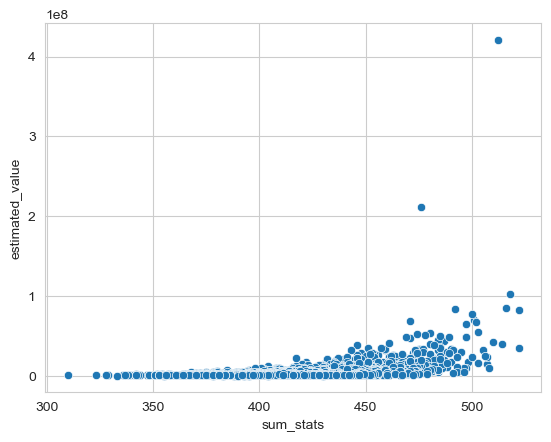

In [33]:
sns.scatterplot(data= df,x= 'sum_stats',y= 'estimated_value')
plt.show()

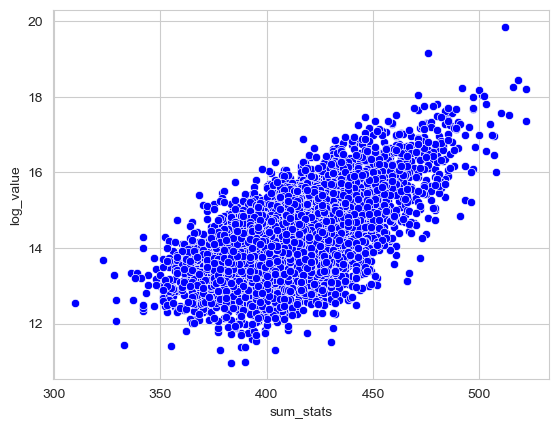

In [43]:

sns.scatterplot(data= df,x= 'sum_stats',y= 'log_value',color= 'blue')

plt.show()

In [ ]:
df.to_csv('value_df.csv')